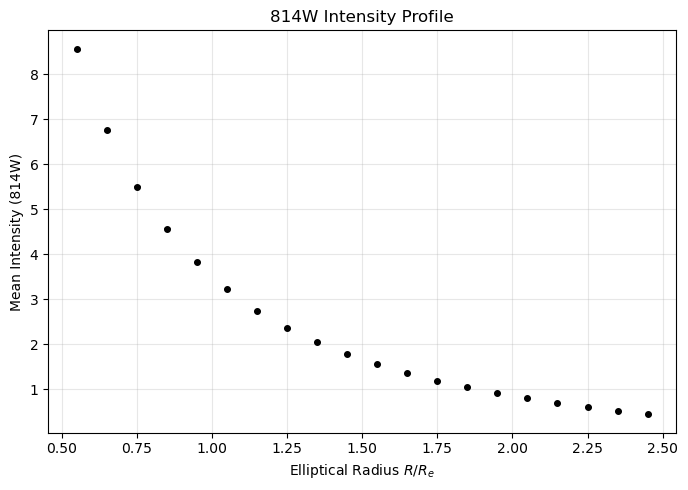

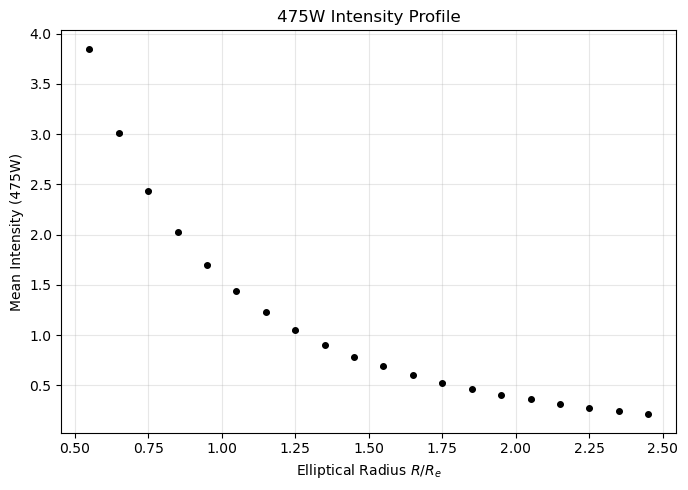

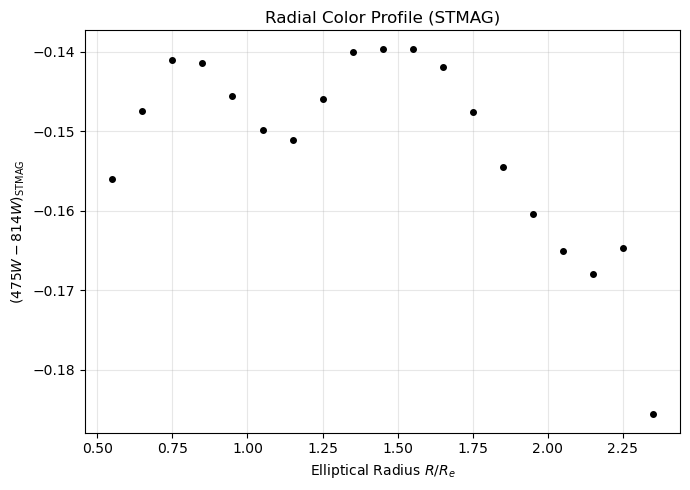


Manual bin rejection:
Rejected bin 15 | R/Re = 2.050 | color = -0.165
Rejected bin 16 | R/Re = 2.150 | color = -0.168
Rejected bin 17 | R/Re = 2.250 | color = -0.165
Rejected bin 18 | R/Re = 2.350 | color = -0.186

Final mean color (simple average):
(475W - 814W)_STMAG = -0.147 ± 0.006 mag
Bins used: 15 / 19


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ============================================================
# PHOTOMETRIC CONSTANTS (STMAG)
# ============================================================
PHOTZPT_475  = -21.1
PHOTFLAM_475 = 1.8016764e-19

PHOTZPT_814  = -21.1
PHOTFLAM_814 = 7.0143407e-20


# ============================================================
# 1. READ INTENSITY PROFILES
# ============================================================
f475 = pd.read_csv("475Wint.csv")
f814 = pd.read_csv("814Wint.csv")

f475 = f475.sort_values("R_over_Re")
f814 = f814.sort_values("R_over_Re")


# ============================================================
# 2. PLOT INTENSITY PROFILES
# ============================================================
plt.figure(figsize=(7, 5))
plt.errorbar(
    f814["R_over_Re"],
    f814["Mean_Intensity"],
    yerr=f814["Std_Intensity"],
    fmt="ko",
    ms=4,
    capsize=2
)
plt.xlabel(r"Elliptical Radius $R/R_e$")
plt.ylabel("Mean Intensity (814W)")
plt.title("814W Intensity Profile")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.errorbar(
    f475["R_over_Re"],
    f475["Mean_Intensity"],
    yerr=f475["Std_Intensity"],
    fmt="ko",
    ms=4,
    capsize=2
)
plt.xlabel(r"Elliptical Radius $R/R_e$")
plt.ylabel("Mean Intensity (475W)")
plt.title("475W Intensity Profile")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# 3. INTERPOLATE 475W ONTO 814W RADIAL GRID
# ============================================================
interp_I475 = interp1d(
    f475["R_over_Re"],
    f475["Mean_Intensity"],
    kind="linear",
    bounds_error=False,
    fill_value=np.nan
)

interp_S475 = interp1d(
    f475["R_over_Re"],
    f475["Std_Intensity"],
    kind="linear",
    bounds_error=False,
    fill_value=np.nan
)

R    = f814["R_over_Re"].values
I814 = f814["Mean_Intensity"].values
S814 = f814["Std_Intensity"].values

I475 = interp_I475(R)
S475 = interp_S475(R)

# keep only valid bins
good = (
    np.isfinite(I475) &
    np.isfinite(I814) &
    (I475 > 0) &
    (I814 > 0)
)

R    = R[good]
I475 = I475[good]
I814 = I814[good]
S475 = S475[good]
S814 = S814[good]


# ============================================================
# 4. COMPUTE STMAG COLOR
# ============================================================
m475 = (
    -2.5 * np.log10(I475)
    -2.5 * np.log10(PHOTFLAM_475)
    + PHOTZPT_475
)

m814 = (
    -2.5 * np.log10(I814)
    -2.5 * np.log10(PHOTFLAM_814)
    + PHOTZPT_814
)

color = m475 - m814


# ============================================================
# 5. PLOT COLOR vs RADIAL DISTANCE
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(R, color, "ko", ms=4)
plt.xlabel(r"Elliptical Radius $R/R_e$")
plt.ylabel(r"$(475W - 814W)_{\rm STMAG}$")
plt.title("Radial Color Profile (STMAG)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# 6. MANUAL LIST OF BINS TO NEGLECT (YOU EDIT THIS)
# ============================================================
# 0-based indices of bins to ignore during averaging
neglect_bins = [
    15, 16, 17, 18
]

neglect_bins = np.array(neglect_bins, dtype=int)

use_mask = np.ones(len(color), dtype=bool)
use_mask[neglect_bins] = False


# ============================================================
# 7. MEAN COLOR AND STANDARD DEVIATION (MANUAL SELECTION)
# ============================================================
mean_color = np.mean(color[use_mask])
std_color  = np.std(color[use_mask])

print("\nManual bin rejection:")
for i in neglect_bins:
    print(f"Rejected bin {i:2d} | R/Re = {R[i]:.3f} | color = {color[i]:.3f}")

print("\nFinal mean color (simple average):")
print(f"(475W - 814W)_STMAG = {mean_color:.3f} ± {std_color:.3f} mag")
print("Bins used:", np.sum(use_mask), "/", len(color))


I will ad an extra 0.01 to the error for systematics

In [2]:
from acstools import acszpt
q = acszpt.Query(date="2003-02-01", detector="WFC")
zpt_table = q.fetch()
print(zpt_table)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F435W   4329.1                    3.1004e-19  25.171  25.797  25.681
 F475W   4745.6                    1.8016e-19  25.761  26.179  26.071
 F502N   5023.0                    5.1781e-18  22.115  22.392  22.302
 F550M   5581.3                    3.9449e-19   24.91  24.846  24.868
 F555W   5360.2                    1.9411e-19   25.68  25.736  25.726
 F606W   5919.8                    7.7453e-20  26.677  26.422  26.508
 F625W   6311.3                    1.1798e-19  26.221  25.746  25.912
 F658N   6584.0                    1.9691e-18  23.164  22.393  22.764
 F660N   6599.4                    5.1475e-18  22.121   21.43  21.715
 F775W   7693.8                    9.8934e-20  26.412  25.275  25.673
 F814W   8047.1                    6.9822e-20   26.79  25.523  25.954
F850LP   9034.3     

In [3]:
from acstools import acszpt
q = acszpt.Query(date="2006-01-24", detector="WFC")
zpt_table = q.fetch()
print(zpt_table)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F435W   4329.3                    3.1193e-19  25.165   25.79  25.675
 F475W   4745.8                    1.8119e-19  25.755  26.173  26.065
 F502N   5023.0                    5.2064e-18  22.109  22.386  22.296
 F550M   5581.3                    3.9667e-19  24.904   24.84  24.862
 F555W   5360.2                    1.9518e-19  25.674   25.73   25.72
 F606W   5919.7                    7.7897e-20  26.671  26.416  26.502
 F625W   6311.2                    1.1867e-19  26.214  25.739  25.906
 F658N   6584.0                    1.9808e-18  23.158  22.387  22.757
 F660N   6599.4                    5.1781e-18  22.115  21.424  21.709
 F775W   7694.0                    9.9462e-20  26.406  25.269  25.667
 F814W   8047.9                    7.0143e-20  26.785  25.517  25.949
F850LP   9034.7     

For NGC\,4874, the mean galaxy color was first measured in the STMAG system as
$
(F475W - F814W)_{\mathrm{STMAG}} = -0.147 ± 0.006 \ \mathrm{mag}.
$

To convert this color to the Vega system, we use the ACS/WFC zeropoint offsets,
defined as
$
\Delta_X = m_X^{\mathrm{VEGA}} - m_X^{\mathrm{STMAG}}.
$

From the ACS photometric calibration tables, the offsets are
$
\Delta_{475} = 0.418, \qquad \Delta_{814} = -1.267.
$

The Vega color is then obtained as
$$
(F475W - F814W)_{\mathrm{VEGA}}
=
(F475W - F814W)_{\mathrm{STMAG}}
+
(\Delta_{475} - \Delta_{814}).
$$

Substituting the values gives
$$
(F475W - F814W)_{\mathrm{VEGA}}
=
-0.147 + 1.685
=
1.538 \ \mathrm{mag}.
$$


 ### So the color is 1.538 ± 0.016 .
 ### Now asking to GPT (😅), the extinction in that direction is 0.039
 ### Also the SBF magnetude in the 814W band is 30.22 ± 0.01